<a href="https://colab.research.google.com/github/magnolia2001/Forest_Estimation/blob/main/notebooks/random_forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive

# 挂载 Google Drive
drive.mount('/content/drive')

# 检查挂载的路径结构
!ls /content/drive

Mounted at /content/drive
MyDrive


In [2]:
root_path = '/content/drive/My Drive/data/'
path_images = f'{root_path}images/'
path_masks = f'{root_path}masks/'

在生成栅格切片和掩膜切片的代码中，输出的 .npy 文件的数据结构应为：

print("Image shape:", image.shape)  # 应为 (11, 1024, 1024)  # 应为 (color_channels, height, width)

print("Mask shape:", mask.shape)    # 应为 (1024, 1024)  # 应为 (height, width)

In [3]:
import os
import numpy as np
import pandas as pd
import datetime, os, cv2
from matplotlib import pyplot as plt
from matplotlib.ticker import StrMethodFormatter
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae, mean_absolute_percentage_error as mape
import joblib


In [4]:

# 制作标签数据和特征数据

# 窗口大小应为奇数，以保证标签在中间
size = 5 #define window size should be odd so that the label is in the middle
# 特征的形状，这里假设每个特征是一个大小为 (size, size) 的窗口，包含 11 个通道
shape = (11, size, size) #define shape of features
# np.ones(shape, dtype=None) 用于创建一个形状为 shape 的数组，并将所有元素初始化为 1.0
# 其中 shape：指定数组的形状，通常是一个整数或元组。 dtype：指定数组元素的数据类型（可选）。如果不指定，默认使用 float64 类型。
# labels1 用于存放标签数据（掩膜）, data1 用于存放提取的特征数据
# np.ones(1)返回的是一个只有一个元素的数组，其中该元素值为 1。
labels1 = np.ones(1) #array for labels
# 创建了一个数组，形状为 shape 即 (11, 5, 5) 的 NumPy 数组，并且所有的元素值都被初始化为 1.0 。
data1 = np.ones(shape) #array for features
# 扩展维度，便于后续拼接操作
data1 = np.expand_dims(data1, axis=0) #expand dimension to concatenate

# 初始化所有索引，初始化为一个空 NumPy 数组
indices_all = np.empty((0, 2), dtype=int)  # 累积所有索引

# 遍历目录中的图像（假设有 20 张图像, 具体数量还需要根据自己的情况修改）
# 在 for j in range(20) 这个遍历过程中，区分 j < 10 和 j >= 10 的目的是为了处理不同的文件命名规则。
# 对于小于 10 的文件名，文件名是 "image_00X.npy"，其中 X 是单个数字（0 到 9）。
# 对于大于等于 10 的文件名，文件名是 "image_0XY.npy"，其中 XY 是两位数的数字（10 到 19）。
for j in range(142): #iterate over images in directory
  if j < 10:
    # 路径填写实际路径
    # 读取图像数据
    X = np.load(f'{path_images}image_00'+ str(j) + '.npy')
    # 读取掩膜数据
    y = np.load(f'{path_masks}mask_00'+ str(j) + '.npy')
    # 移除掩膜图像中的通道维度使其形状变为(height, width)
    # y = y[0, :, :]  # 去掉通道维度，保留二维掩膜图像

    # 选择掩膜图像 y 中所有大于 0 的位置（即标签不为 0 的位置），并返回这些位置的索引。
    # indices 数组返回 N 个元素，其中 N 为掩膜图像 y 中所有大于 0 的元素个数。每个元素都是一个长度为 2 的行向量，表示符合条件元素的行列索引。
    # y > 0 是一个布尔条件，返回一个与 y 相同形状的布尔数组, 如果是大于 0，布尔值为 True，否则为 False。
    # np.argwhere() 是 NumPy 库中的一个函数，它返回数组中满足某个条件的所有索引（行列坐标），即满足条件的元素的坐标位置。
    # 这里 indices 是一个形状为 (N, 2) 的二维数组，每一行是 (y, x) 坐标. y 为行索引, x 为列索引
    # indices = np.argwhere(y > 0) #select all values with label
    # indices = np.argwhere((y > 2.34) & (y < 127.58))
    # 筛选掩膜中有效的标签（大于2.34且小于127.58），并且遥感影像中只要任何一个通道中存在无效值，就排除掉该像元及其对应的掩膜值
    indices = np.argwhere((y > 2.34) & (y < 127.58) & (np.all(X != 0, axis=0)))  # 排除遥感影像中的无效值（0）


    # indices_2d 是 indices 数组的一个切片，是一个 二维数组, 它包含了所有掩膜图像中标签值大于 0 的位置的 列索引。
    # 切片操作 indices[:, 1:] 就是提取所有行中的第二列（即 行 和 列 坐标中的 列索引）。
    # indices_2d = indices[:, 1:] #extract indices

    # 初始化一个数组 ind_y 来收集符合条件的标签位置。
    # np.ones(2) 会创建一个包含 2 个元素的数组，所有元素的值为 1. 。
    # .reshape(-1, 2) 将该数组的形状重塑为 (-1, 2)，表示按列数为 2 进行重塑，-1 表示自动计算行数。由于只有 2 个元素，这会将数组变成形状为 (1, 2) 的二维数组。
    ind_y = np.ones(2).reshape(-1,2) #array to collect indices

    # 遍历掩膜中的每个标签位置
    # for i in indices_2d: #iterate over indices
    for i in indices:
      # 提取图像块，并检查其形状。
      # size//2 表示 size 除以 2 的整数部分，用于确定图像块中心点到边界的距离。右端点的值之所以加 1 是因为区间是左闭右开的,所以加 1 保证能取到右端点.
      # 整个i[0] - (size//2):i[0] + (size//2) + 1, i[1] - (size//2):i[1] + (size//2)表达式计算出一个范围，用于选取以 (i[0], i[1])（标签的 y, x 坐标） 为中心，上下各延伸 size//2 个像素的区域。
      # i[0] 是当前标签位置的 y 坐标（行索引）。i[1] 是当前标签位置的 x 坐标（列索引）。
      # 利用 shape 确保当前窗口大小与指定的窗口大小一致
      if shape == X[:, i[0] - (size//2):i[0] + (size//2) + 1, i[1] - (size//2):i[1] + (size//2) + 1].shape: #select only features with the same shape because of labels at the image border
        temp = X[:, i[0] - (size//2):i[0] + (size//2) + 1, i[1] - (size//2):i[1] + (size//2) + 1] #save them temporary
        # 将 temp 的维度扩展一个维度，使得它变成一个形状为 (1, channels, size, size) 的四维数组。扩展维度的目的是为了能够将 temp 与其他提取的窗口进行拼接。
        temp2 = np.expand_dims(temp, axis=0) #expand dimension to concatenate
        # 拼接特征数据
        # data1 最终会变成 (num_samples, 11, 5, 5)，其中 num_samples 是提取的窗口数量。
        data1 = np.concatenate((data1, temp2), axis=0) #concatenation
        # 拼接标签索引
        # i.reshape(-1, 2) 会把 i 重新调整为一个形状为 (1, 2) 的二维数组
        # axis=0 表示在 第 0 维（行方向） 进行拼接，即新添加的行会被添加到原数组的最后。
        # ind_y 则是一个 (num_samples, 2) 的数组，每个样本对应一个标签位置的 (y, x) 坐标。
        ind_y = np.concatenate((ind_y, i.reshape(-1,2)), axis=0) #concatenation of index so that they have the same order and length as the features

    # 去掉第一个虚拟值
    # 初始时，ind_y 中的第一个元素是 np.ones(2).reshape(-1,2) 创建的虚拟数据。此步骤是将它移除，只保留实际的标签坐标。
    ind_y = ind_y[1:] #remove first dummy values
    # 提取所有的行索引
    indices_1 = ind_y[:, 0].astype(int)
    # 提取所有的列索引
    indices_2 = ind_y[:, 1].astype(int)
    # 提取标签值
    # 从这句代码应该可以看出原作者的掩膜图像的形状包含了通道维度,即形状为(1, height, width)
    # data_y = y[0, indices_1, indices_2] #extract labels
    data_y = y[indices_1, indices_2]  # 提取标签
    # 拼接标签，形成最终的标签数组。
    labels1 = np.concatenate((labels1, data_y), axis = 0) #concatenate labels

    # 累积所有 .npy 文件中的索引
    indices_all = np.vstack((indices_all, ind_y))

  if j >= 10 and j < 100:
    X = np.load(f'{path_images}image_0'+ str(j) + '.npy')
    y = np.load(f'{path_masks}mask_0'+ str(j) + '.npy')
    # 移除掩膜图像中的通道维度使其形状变为(height, width)
    # y = y[0, :, :]  # 去掉通道维度，保留二维掩膜图像
    # indices = np.argwhere(y > 0)
    # indices = np.argwhere((y > 2.34) & (y < 127.58))
    # 筛选掩膜中有效的标签（大于2.34且小于127.58），并且遥感影像中只要任何一个通道中存在无效值，就排除掉该像元及其对应的掩膜值
    indices = np.argwhere((y > 2.34) & (y < 127.58) & (np.all(X != 0, axis=0)))  # 排除遥感影像中的无效值（0）

    # indices_2d = indices[:, 1:]
    ind_y = np.ones(2).reshape(-1,2)
    # for i in indices_2d:
    for i in indices:
      if shape == X[:, i[0] - (size//2):i[0] + (size//2) + 1, i[1] - (size//2):i[1] + (size//2) + 1].shape:
        temp = X[:, i[0] - (size//2):i[0] + (size//2) + 1, i[1] - (size//2):i[1] + (size//2) + 1]
        temp2 = np.expand_dims(temp, axis=0)
        data1 = np.concatenate((data1, temp2), axis=0)

        ind_y = np.concatenate((ind_y, i.reshape(-1,2)), axis=0)

    # 去掉第一个虚拟值
    ind_y = ind_y[1:]
    # 提取所有的行索引
    indices_1 = ind_y[:, 0].astype(int)
    # 提取所有的列索引
    indices_2 = ind_y[:, 1].astype(int)
    # data_y = y[0, indices_1, indices_2]
    # 提取标签值
    # 每一对 (indices_1[i], indices_2[i]) 会自动匹配，得到对应位置的标签值。
    data_y = y[indices_1, indices_2]  # 提取标签
    # 拼接标签，形成最终的标签数组。
    labels1 = np.concatenate((labels1, data_y), axis = 0)

    # 累积所有 .npy 文件中的索引
    indices_all = np.vstack((indices_all, ind_y))

  if j >= 100:
    X = np.load(f'{path_images}image_'+ str(j) + '.npy')
    y = np.load(f'{path_masks}mask_'+ str(j) + '.npy')
    # 移除掩膜图像中的通道维度使其形状变为(height, width)
    # y = y[0, :, :]  # 去掉通道维度，保留二维掩膜图像
    # indices = np.argwhere(y > 0)
    # indices = np.argwhere((y > 2.34) & (y < 127.58))
    # 筛选掩膜中有效的标签（大于2.34且小于127.58），并且遥感影像中只要任何一个通道中存在无效值，就排除掉该像元及其对应的掩膜值
    indices = np.argwhere((y > 2.34) & (y < 127.58) & (np.all(X != 0, axis=0)))  # 排除遥感影像中的无效值（0）

    # indices_2d = indices[:, 1:]
    ind_y = np.ones(2).reshape(-1,2)
    # for i in indices_2d:
    for i in indices:
      if shape == X[:, i[0] - (size//2):i[0] + (size//2) + 1, i[1] - (size//2):i[1] + (size//2) + 1].shape:
        temp = X[:, i[0] - (size//2):i[0] + (size//2) + 1, i[1] - (size//2):i[1] + (size//2) + 1]
        temp2 = np.expand_dims(temp, axis=0)
        data1 = np.concatenate((data1, temp2), axis=0)

        ind_y = np.concatenate((ind_y, i.reshape(-1,2)), axis=0)

    # 去掉第一个虚拟值
    ind_y = ind_y[1:]
    # 提取所有的行索引
    indices_1 = ind_y[:, 0].astype(int)
    # 提取所有的列索引
    indices_2 = ind_y[:, 1].astype(int)
    # data_y = y[0, indices_1, indices_2]
    # 提取标签值
    # 每一对 (indices_1[i], indices_2[i]) 会自动匹配，得到对应位置的标签值。
    data_y = y[indices_1, indices_2]  # 提取标签
    # 拼接标签，形成最终的标签数组。
    labels1 = np.concatenate((labels1, data_y), axis = 0)

    # 累积所有 .npy 文件中的索引
    indices_all = np.vstack((indices_all, ind_y))

# 移除第一个虚拟值
# data1 的形状会是 (num_samples, 11, 5, 5)，其中 num_samples 是提取的窗口数量（即符合条件的标签数量）。一个四维数组
# labels1 的形状会是 (num_samples,)，其中 num_samples 是所有图像中符合条件的标签数量。一个一维数组
data1 = data1[1:] #remove first dummy values
labels1 = labels1[1:] #remove first dummy values

# data1 和 labels1 应该是 一一对应的，因为它们的样本数（num_samples）相同。
# 获得标签数据和特征数据
features = data1
labels = labels1


In [5]:
# 计算数据增强前的标签的统计信息
print("数据导入后且数据增强前的标签的统计信息：")
print(f"  最大值: {np.max(labels)}")
print(f"  最小值: {np.min(labels)}")
print(f"  均值: {np.mean(labels)}")
print(f"  标准差: {np.std(labels)}")

数据导入后且数据增强前的标签的统计信息：
  最大值: 126.9000015258789
  最小值: 2.3499999046325684
  均值: 19.320443178496898
  标准差: 9.943414712274128


### 数据增强

In [6]:
# import tensorflow as tf
# from tensorflow import keras

# # 1. 数据增强管道（仅对特征操作）
# data_augmentation = tf.keras.Sequential([
#     keras.layers.RandomFlip("horizontal_and_vertical"),
#     keras.layers.RandomRotation(0.2),
#     keras.layers.RandomZoom(0.1),  # 随机缩放
#     keras.layers.GaussianNoise(0.01),  # 为特征添加轻微的高斯噪声
# ])

# # 2. 仅增强特征，保持标签不变
# def augment_feature_label(feature, label):
#     """
#     对特征进行增强，标签保持不变。
#     """
#     # 转换特征格式为 (H, W, C) 以便增强
#     feature = tf.transpose(feature, perm=[1, 2, 0])  # (11, 5, 5) -> (5, 5, 11)

#     # 仅对特征进行增强
#     augmented_feature = data_augmentation(feature)

#     # 恢复特征原始格式 (C, H, W)
#     augmented_feature = tf.transpose(augmented_feature, perm=[2, 0, 1])  # (5, 5, 11) -> (11, 5, 5)

#     # 标签保持不变
#     return augmented_feature, label

# # 3. 对所有样本进行数据增强
# augmented_features = []
# augmented_labels = []

# for i in range(features.shape[0]):
#     feature = tf.convert_to_tensor(features[i], dtype=tf.float32)
#     label = tf.convert_to_tensor(labels[i], dtype=tf.float32)

#     aug_feature, aug_label = augment_feature_label(feature, label)
#     augmented_features.append(aug_feature)
#     augmented_labels.append(aug_label)

# # 转换为 NumPy 数组
# augmented_features = np.stack(augmented_features)
# augmented_labels = np.array(augmented_labels)

# # # 打印验证形状
# # print("增强后的特征形状:", augmented_features.shape)  # (num_samples, 11, 5, 5)
# # print("增强后的标签形状:", augmented_labels.shape)  # (num_samples,)

# # features = augmented_features
# # labels = augmented_labels


In [7]:
# # 打印验证形状
# print("增强后的特征形状:", augmented_features.shape)  # (num_samples, 11, 5, 5)
# print("增强后的标签形状:", augmented_labels.shape)  # (num_samples,)

# features = augmented_features
# labels = augmented_labels

In [8]:
# # 计算数据增强后的标签的统计信息
# print("数据增强后的标签的统计信息：")
# print(f"  最大值: {np.max(labels)}")
# print(f"  最小值: {np.min(labels)}")
# print(f"  均值: {np.mean(labels)}")
# print(f"  标准差: {np.std(labels)}")

In [9]:
# # 每个类别的样本数，确保每个标签区间有 800 个样本
# sample_size = 800 #every class with labels smaller 36 meters has over 800 values
# #features = np.mean(features, axis=(2, 3)) # patch mean of size * size features

# # 生成从 3 到 36 步长为 3 的数字列表，即 [3, 6, 9, ..., 36]
# num = (list(range(3, 37, 3))) #create list from 3 to 36 step 3
# # 假设每个样本是一个 5x5 的图像块（大小为 5x5，90 个通道）
# shape = (11, 5, 5)
# # 创建一个初始的数组用于存储特征数据，形状为 (90, 5, 5)
# data_bal = np.ones(shape) #create array to fill with features
# # 扩展维度，使得形状变为 (1, 11, 5, 5)，这样可以进行拼接
# data_bal = np.expand_dims(data_bal, axis=0) #expand one dimension to concatenate
# # 创建一个用于存储标签的初始数组，形状为 (1,)
# data_lab = np.ones(1) #create array to fill labels

# # 在抽样之前，打印每个区间的样本数量，确保逻辑合理。
# # 遍历每个标签区间
# for i in num:
#   # 注意这个 i 是区间右端点
#   # 从标签中选择属于当前区间的索引
#   # np.where() 返回的是一个元组，元组的元素个数取决于判断条件中的数据的维度, 元组的每个元素都是一个 数组，这些数组表示满足条件的元素在原始数组中的索引。因此，需要通过 indices[0] 访问索引数组
#   # 如果输入数组是 多维的，返回的元组会包含 每一维的索引数组。例如，若数组是三维的，返回的元组就会包含三个数组，分别表示满足条件的元素在三维空间中每一维的索引。
#   indices = np.where((labels > i-3) & (labels <= i)) #select indcies from every 3 meter interval until 36
#   print(f"区间 ({i-3}, {i}] 的样本数: {len(indices[0])}")

#   # 根据样本数决定如何抽样
#   if len(indices[0]) < sample_size:
#       print(f"样本不足800，仅有 {len(indices[0])} 个样本，允许重复抽样。")
#       sampled_indices = np.random.choice(indices[0], size=sample_size, replace=True)
#   else:
#       sampled_indices = np.random.choice(indices[0], size=sample_size, replace=False)


#   # 在当前区间中随机抽样 800 个样本
#   # sampled_indices = np.random.choice(indices[0].flatten(), size=sample_size, replace=False) #random sample of each interval
#   # sampled_indices = np.random.choice(indices[0], size=sample_size, replace=False)

#   # 提取对应的特征和标签
#   tempx = features[sampled_indices]
#   tempy = labels[sampled_indices]
#   # 将当前区间的特征和标签拼接到平衡数组中
#   data_bal = np.concatenate((data_bal, tempx), axis=0)
#   data_lab = np.concatenate((data_lab, tempy), axis=0)

# # 处理 labels > 36 的标签，这部分直接拼接
# indices = np.where((labels > 36)) #add the values > 36 m, they are so few no sample needed
# # sampled_indices = indices[0].flatten()
# sampled_indices = indices[0]
# tempx = features[sampled_indices]
# tempy = labels[sampled_indices]
# data_bal = np.concatenate((data_bal[1:], tempx), axis=0)
# data_lab = np.concatenate((data_lab[1:], tempy), axis=0)

# # # 为了配合可视化界面，这里将data_bal重新赋值给features将data_lab重新赋值给labels，以便后续能够使用统一的变量。
# features = data_bal
# labels = data_lab


# random_forest

In [10]:
# 数据集拆分：训练集和测试集
# X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size = 0.3, random_state=3) #create train, test set

# features 数组形状为 (num_samples, 11, 5, 5)，意味着每个样本有 11 个特征（或 11 个通道），每个特征是一个 5x5 的空间窗口。
features_mean = np.mean(features, axis=(2, 3)) # patch mean of size * size features

# 现在 features_mean 的形状是 (num_samples, 11)，适用于NN或者其他传统机器学习算法
# 注意: train_test_split 只能处理 NumPy 数组或 Pandas DataFrame，并不能直接处理 TensorFlow Dataset 对象。因此，这部分代码在处理 TensorFlow Dataset 时会出错。
# X_train, X_test, y_train, y_test = train_test_split(features_mean, labels, test_size = 0.3, random_state=3)


In [11]:
# 完整数据集：针对每个特征维度（即 11 个通道）计算统计信息
for i in range(features_mean.shape[1]):  # 遍历 11 个特征通道
    print(f"完整数据集：特征通道 {i+1} 的统计信息：")
    print(f"  最大值: {np.max(features_mean[:, i])}")
    print(f"  最小值: {np.min(features_mean[:, i])}")
    print(f"  均值: {np.mean(features_mean[:, i])}")
    print(f"  标准差: {np.std(features_mean[:, i])}")


完整数据集：特征通道 1 的统计信息：
  最大值: 1780.6
  最小值: 1.72
  均值: 273.4130494740254
  标准差: 267.23430645557636
完整数据集：特征通道 2 的统计信息：
  最大值: 38.57611770629883
  最小值: 2.824326934814453
  均值: 22.40610370795799
  标准差: 3.655487898055712
完整数据集：特征通道 3 的统计信息：
  最大值: 42.49605651855469
  最小值: 3.3621476745605468
  均值: 25.855961396453147
  标准差: 4.245746591962218
完整数据集：特征通道 4 的统计信息：
  最大值: 42.191317596435546
  最小值: 3.373607940673828
  均值: 25.85583949618395
  标准差: 4.258626579802282
完整数据集：特征通道 5 的统计信息：
  最大值: 0.9352188277244567
  最小值: 0.05555133700370789
  均值: 0.7681205759628675
  标准差: 0.10101240198620785
完整数据集：特征通道 6 的统计信息：
  最大值: 2.4315512132644654
  最小值: 0.006718133091926575
  均值: 0.15055681400745216
  标准差: 0.09813815663711081
完整数据集：特征通道 7 的统计信息：
  最大值: 133.32
  最小值: 0.52
  均值: 23.71349559477856
  标准差: 15.904786590202246
完整数据集：特征通道 8 的统计信息：
  最大值: 298.52
  最小值: 1.56
  均值: 56.699736570704545
  标准差: 39.57387453083753
完整数据集：特征通道 9 的统计信息：
  最大值: 464.32
  最小值: 1.68
  均值: 86.39910952647551
  标准差: 62.11900645937374
完整数据集

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 39057 (\N{CJK UNIFIED IDEOGRAPH-9891}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 29305 (\N{CJK UNIFIED IDEOGRAPH-7279}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 24449 (\N{CJK UNIFIED IDEOGRAPH-5F81}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 36890 (\N{CJK UNIFIED IDEOGRAPH-901A}) missing from font(s) DejaVu Sans.
  fig.canvas

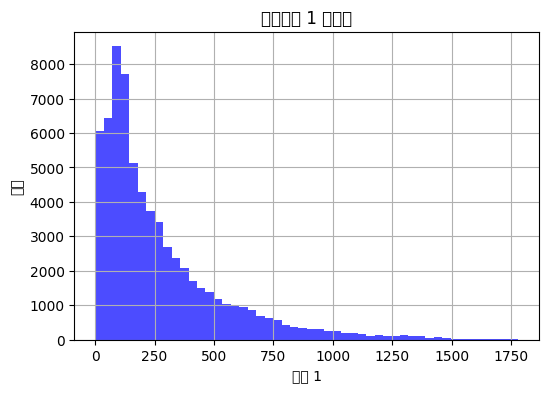

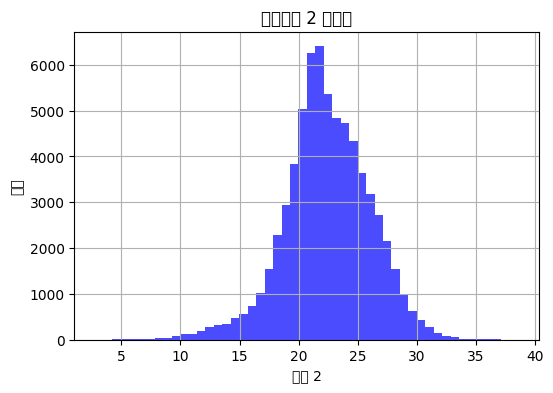

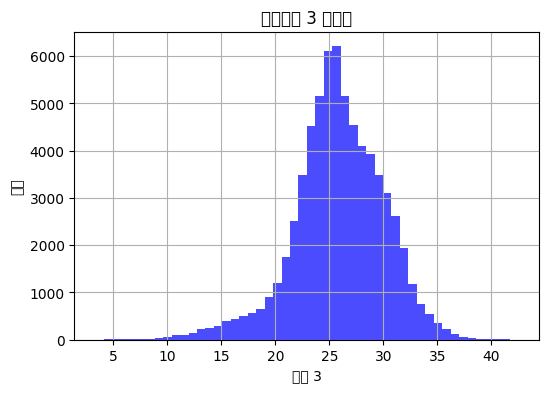

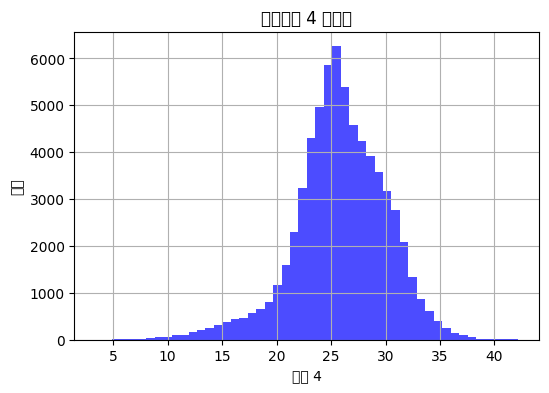

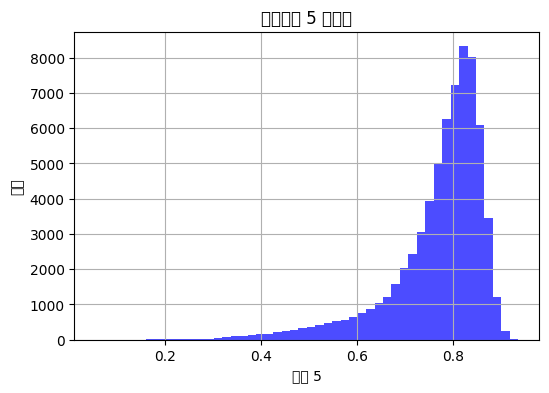

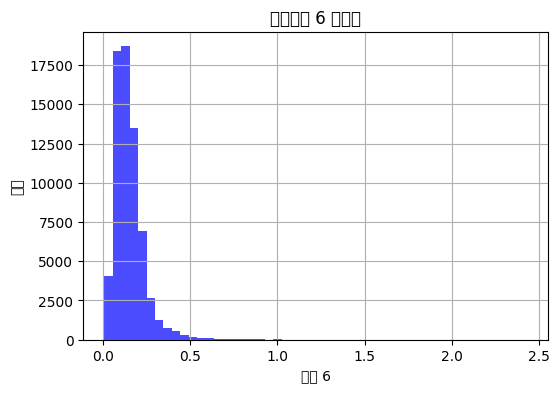

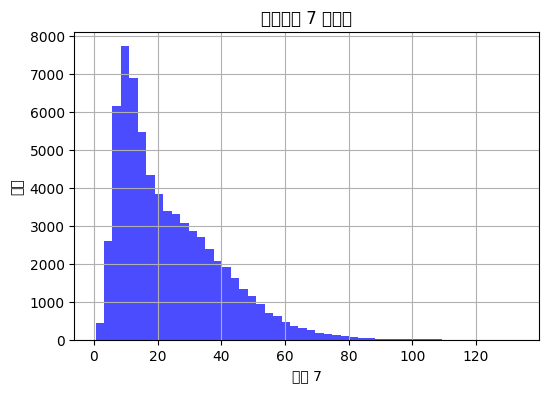

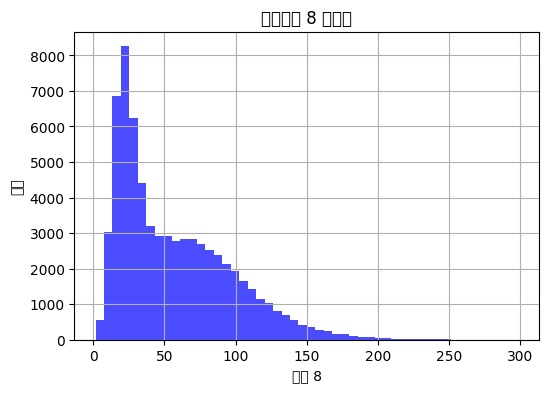

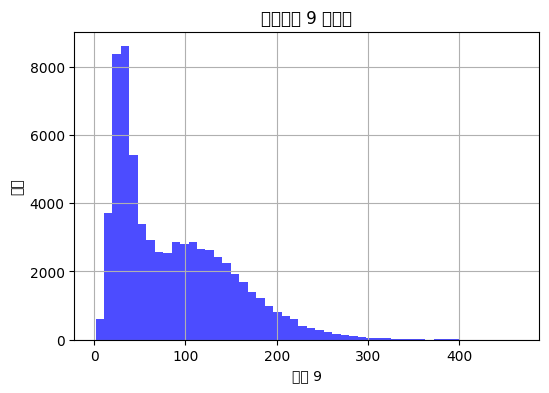

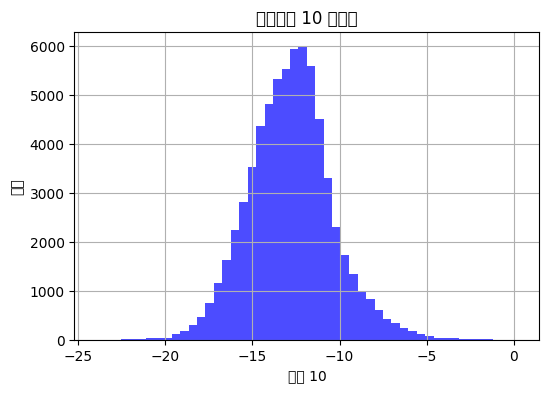

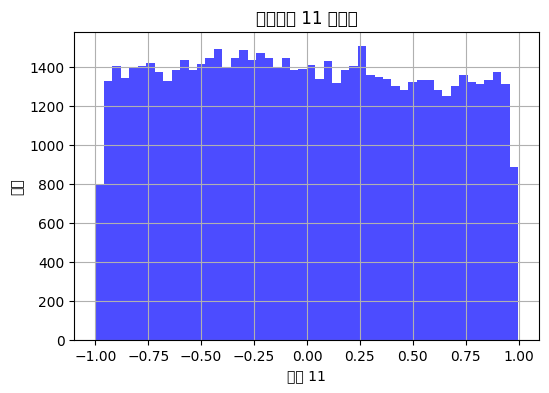

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 26631 (\N{CJK UNIFIED IDEOGRAPH-6807}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 31614 (\N{CJK UNIFIED IDEOGRAPH-7B7E}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20540 (\N{CJK UNIFIED IDEOGRAPH-503C}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


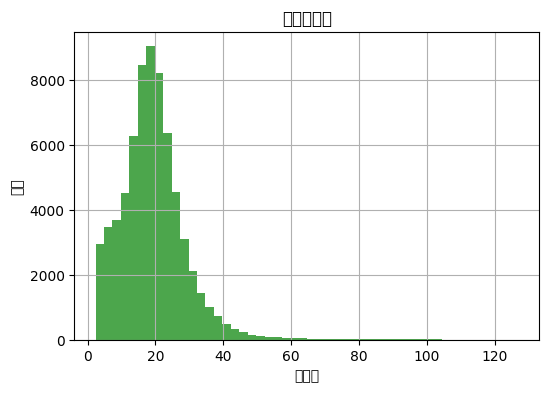

In [12]:
import matplotlib.pyplot as plt

# 2. 绘制特征的直方图、标签的分布图

# 绘制特征的直方图
for i in range(features_mean.shape[1]):
    plt.figure(figsize=(6, 4))
    plt.hist(features_mean[:, i], bins=50, color='blue', alpha=0.7)
    plt.title(f"特征通道 {i+1} 的分布")
    plt.xlabel(f"特征 {i+1}")
    plt.ylabel("频数")
    plt.grid(True)
    plt.show()

# 绘制标签的分布图
plt.figure(figsize=(6, 4))
plt.hist(labels, bins=50, color='green', alpha=0.7)
plt.title("标签的分布")
plt.xlabel("标签值")
plt.ylabel("频数")
plt.grid(True)
plt.show()


特征之间的相关性矩阵：
[[ 1.          0.19552941  0.27362393  0.28036082  0.37089366  0.20056279
   0.60784539  0.66204577  0.69963213  0.02061854  0.01382787]
 [ 0.19552941  1.          0.90613506  0.90892022  0.36999484  0.56082544
   0.21758334  0.23171293  0.23766523  0.25528082 -0.40942071]
 [ 0.27362393  0.90613506  1.          0.99335588  0.55403408  0.56474451
   0.28367953  0.3044083   0.31435908  0.25500298 -0.34458292]
 [ 0.28036082  0.90892022  0.99335588  1.          0.56593518  0.55150277
   0.29008117  0.30905424  0.31776833  0.24034126 -0.32011196]
 [ 0.37089366  0.36999484  0.55403408  0.56593518  1.          0.13308308
   0.40668559  0.42087945  0.42518512 -0.23520986  0.15011249]
 [ 0.20056279  0.56082544  0.56474451  0.55150277  0.13308308  1.
   0.15571022  0.16402458  0.16826541  0.71071755 -0.4828078 ]
 [ 0.60784539  0.21758334  0.28367953  0.29008117  0.40668559  0.15571022
   1.          0.95110845  0.88935045 -0.07381745  0.01797557]
 [ 0.66204577  0.23171293  0.3044083 

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 29305 (\N{CJK UNIFIED IDEOGRAPH-7279}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 24449 (\N{CJK UNIFIED IDEOGRAPH-5F81}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20043 (\N{CJK UNIFIED IDEOGRAPH-4E4B}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 38388 (\N{CJK UNIFIED IDEOGRAPH-95F4}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 30340 (\N{CJK UNIFIED IDEOGRAPH-7684}) missing from font(s) DejaVu Sans.
  fig.canvas

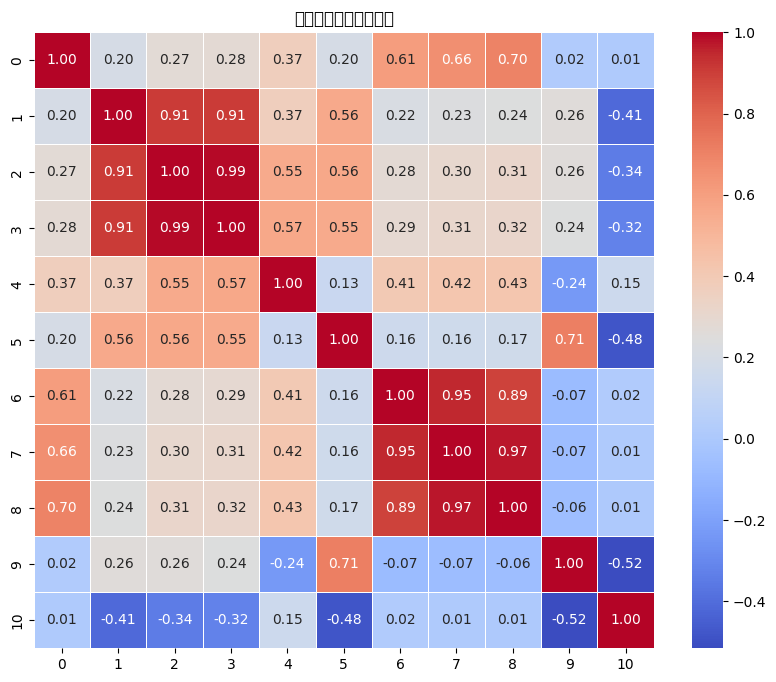

特征 2 和 特征 3 之间的相关性为 0.91
特征 2 和 特征 4 之间的相关性为 0.91
特征 3 和 特征 4 之间的相关性为 0.99
特征 7 和 特征 8 之间的相关性为 0.95
特征 8 和 特征 9 之间的相关性为 0.97


In [13]:
# 3. 计算并输出特征之间的相关性矩阵，并标明是否存在高度相关的特征：

import seaborn as sns

# 计算特征之间的相关性矩阵
corr_matrix = np.corrcoef(features_mean, rowvar=False)

# 输出相关性矩阵
print("特征之间的相关性矩阵：")
print(corr_matrix)

# 可视化相关性矩阵
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("特征之间的相关性矩阵")
plt.show()

# 检查高度相关的特征：阈值可以根据实际情况调整
threshold = 0.9
highly_correlated_features = np.where(np.abs(corr_matrix) > threshold)
for i, j in zip(*highly_correlated_features):
    if i < j:  # 避免重复输出
        print(f"特征 {i+1} 和 特征 {j+1} 之间的相关性为 {corr_matrix[i, j]:.2f}")


### 特征标准化

通常情况下，如果每个通道的特征是互相独立的，并且它们的取值范围差异较大（例如，不同通道的数据量级不同），那么对每个通道单独进行标准化可能是更好的做法。

可以在 StandardScaler 中针对每个通道（即每个特征）进行单独标准化，而不是直接对整个 X_train 和 X_test 标准化。

在标准化特征时，使用 训练集 来拟合标准化器（如 StandardScaler），并用其参数（均值和标准差）对测试集进行变换，这是一种 防止数据泄露 的必要操作。

标准化的正确流程：

用训练集计算标准化参数（如均值和标准差）。
用这些参数对训练集和测试集分别进行标准化。

In [14]:
# from sklearn.preprocessing import StandardScaler

# # 因为对于每个特征i来说，正确的做法应该是用X_train的第i列的均值和标准差来标准化对应的测试集的第i列。
# # 在同一个循环中，处理完X_train的第i列之后，处理X_test的第i列时，即对每个特征i，分别创建一个scaler实例，保存该特征的均值和标准差，然后在处理测试集时，用对应的scaler来处理对应的特征。

# # fit_transform()：计算训练集的统计参数（均值和标准差）。根据这些参数对数据进行标准化。适用于训练集
# # 仅用训练集数据拟合标准化器（避免数据泄露）
# # X_train = scaler.fit_transform(X_train)

# # transform()：不会重新计算统计参数，而是使用 fit_transform() 计算出的参数对数据进行标准化。适用于测试集（或者未来的预测数据）。
# # 使用训练集的标准化参数变换测试集
# # X_test = scaler.transform(X_test)

# # 对每个特征通道（即每列）分别进行标准化
# # X_train 和 X_test 的形状是 (num_samples, 11)，其中 11 表示每个样本的特征数。
# # 应为每个特征通道单独创建一个 StandardScaler 实例，确保测试集每个通道使用对应训练集通道的统计量。

# # 初始化一个列表保存每个特征的标准化器
# scalers = []

# # 对 训练集X_train 中每个特征（通道）进行标准化
# X_train_standardized = np.copy(X_train)  # 创建一个 X_train 的副本，避免修改原始数据
# for i in range(X_train.shape[1]):  # 遍历每个特征（通道）
#     scaler = StandardScaler()  # 为每个特征创建新的标准化器
#     X_train_standardized[:, i] = scaler.fit_transform(X_train[:, i].reshape(-1, 1)).flatten()  # 对每个特征进行 fit_transform
#     scalers.append(scaler)  # 保存当前特征的标准化器

# X_train = X_train_standardized

# # 对 测试集X_test 中每个特征（通道）使用对应训练集的标准化器进行标准化
# X_test_standardized = np.copy(X_test)  # 创建一个 X_test 的副本
# for i in range(X_test.shape[1]):  # 遍历每个特征（通道）
#     scaler = scalers[i]  # 获取对应特征的标准化器
#     X_test_standardized[:, i] = scaler.transform(X_test[:, i].reshape(-1, 1)).flatten()  # 使用训练集的标准化参数对测试集进行 transform

# X_test = X_test_standardized


In [15]:
# # 检查特征标准化之后的数据集的每个特征维度（即 11 个通道）的统计信息
# for i in range(X_train.shape[1]):  # 遍历 11 个特征通道
#     print(f"训练集特征通道 {i+1} 的统计信息：")
#     print(f"  最大值: {np.max(X_train[:, i])}")
#     print(f"  最小值: {np.min(X_train[:, i])}")
#     print(f"  均值: {np.mean(X_train[:, i])}")
#     print(f"  标准差: {np.std(X_train[:, i])}")

# for i in range(X_test.shape[1]):  # 遍历 11 个特征通道
#     print(f"测试集特征通道 {i+1} 的统计信息：")
#     print(f"  最大值: {np.max(X_test[:, i])}")
#     print(f"  最小值: {np.min(X_test[:, i])}")
#     print(f"  均值: {np.mean(X_test[:, i])}")
#     print(f"  标准差: {np.std(X_test[:, i])}")

**Random Search**

In [16]:
# 用于保存机器学习模型到指定路径，以便后续可以重新加载并使用，而不需要重新训练模型。
def save_model(model, modelname):
    """
    保存机器学习模型。

    Parameters
    ----------
    model: sklearn.ensemble.*
      训练好的机器学习模型。
    model_name: String
      模型名称。

    Returns
    -------
    None
    """

    # Ensure the models directory exists
    os.makedirs('/content/drive/My Drive/forest_height/models/', exist_ok=True)

    # Save the model
    # 始终希望启用压缩，可以直接在 joblib.dump 调用中设置 compress。
    # joblib.dump 函数支持 compress 参数，用于对保存的模型文件进行压缩。启用压缩不会破坏模型，只是减小文件大小。
    # 模型保存时的压缩不会影响模型加载，加载时不需要指定任何参数。
    joblib.dump(model, f'/content/drive/My Drive/forest_height/models/{modelname}.joblib', compress=True)

    print(f"Model saved as '/content/drive/My Drive/forest_height/models/{modelname}.joblib'")

    # 加载保存的模型。加载的模型对象与保存前完全一致，可以直接用于推理或评估，无需重新训练。将其单独定义为一个函数更加方便。
    # load model with:
    # model = joblib.load("forest_height/models/{model_name}.joblib")



# load_model 函数返回的模型与save_model(model, modelname)保存的模型完全一致
def load_model(modelname):
    """
    Load a previously saved model from a .joblib file.

    Parameters
    ----------
    modelname : str
        The name of the saved model file (without extension).

    Returns
    -------
    model : object
        The loaded machine learning model.
    """

    # Define the path to the model
    model_path = f'/content/drive/My Drive/forest_height/models/{modelname}.joblib'

    # Check if the model file exists
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"Model file '{model_path}' does not exist.")

    # Load and return the model
    model = joblib.load(model_path)
    print(f"Model loaded from '{model_path}'")

    return model

In [17]:
# 为了适应不同的数据集，cols 应该动态调整，确保其与数据集的特征对应。
def feature_importance(
    model,
    model_name,
    cols = ['Height', 'HH_Dir4_Mean', 'HV_Dir3_Mean', 'HV_Dir4_Mean', 'Entropy', 'mv', 'RLD12', 'RLD20', 'RLD5', 'sigma_db_HV', 'SinAspect']
    ):
    """
    Visualize feature importance of regression model

    Parameters
    ----------
    model: sklearn.ensemble.*
      一个已经训练好的回归模型，必须具有 feature_importances_ 属性。
    model_name: String
      模型的名称，用于可视化标题中显示。
    cols: Array of Strings
      list（字符串数组）.特征名称列表，用于匹配模型中的特征顺序。如果为 None，则自动生成 ["Feature 1", "Feature 2", ...]。

    Returns
    -------
    None, just prints out feature importances and plots them in a bar graph
      直接打印和绘制特征重要性。
    """
    # 这是一个数组，存储模型中每个特征的重要性分数。
    # importance = model.feature_importances_ 这个数组的长度与为喂给model进行训练模型的数据集中的特征数量一致，即importance 的长度等于训练数据集中特征的数量。
    importance = model.feature_importances_

    # summarize feature importance
    # 打印特征重要性
    # enumerate(importance) 枚举特征重要性数组，i 是特征索引，v 是对应的重要性分数
    for i,v in enumerate(importance):
        # 简单地用特征索引（Feature: 0、Feature: 1 等）来表示特征。
        print('Feature: %0d, Score: %.5f' % (i,v))

    # 如果没有传入 cols，则动态生成
    if cols is None:
        cols = [f"Feature {i}" for i in range(len(importance))]
    elif len(cols) != len(importance):
        raise ValueError("Length of 'cols' does not match number of features in the model.")

    # plot feature importance
    # 将图像宽度适当拉长，使其能够容纳更多的特征名称。
    # plt.figure(figsize=(20, 10))  # 宽20，高10
    # cols：x 轴的特征名称（列表）。  importance：y 轴的特征重要性分数。  color=color：条形图的颜色（需要外部定义 color，否则会报错）。
    plt.bar(cols, importance, color="#01748F")
    # 设置 x 轴标签
    plt.xlabel("Features")
    # 设置 y 轴标签
    plt.ylabel("Feature Importance")
    # 图表标题，显示模型名称
    plt.title(f"Feature Importance of {model_name} Regression")
    plt.xticks(rotation=45)  # 调整标签角度，避免标签之间的重叠
    # 显示图表
    plt.show()



In [18]:

def pred_vs_true(model, model_name):
    """
    Visualize predictions and compare them to the labeled data

    Parameters
    ----------
    model: sklearn.ensemble.*
      训练好的机器学习模型，用于预测。通过 model.predict(X_test) 生成预测值。
    model_name: String
      字符串，表示模型名称，用于可视化时的标题显示。

    该函数不输入数据集，直接使用在前面代码中划分的数据集数据集即可。

    Returns
    -------
    None, just prints out errors of each dataset
      该函数没有返回值，仅通过两种可视化方式展示预测值和真实值的关系：
      1.整体预测值 vs. 真实值的散点图。点为蓝色点。展示模型整体性能：预测值和真实值是否接近对角线。
      2.单一通道（特征） vs. 森林高度的散点图。黑色点为真实值，蓝色点为预测值。分别展示两个特定通道（第四通道和第五通道）特征与森林高度（真实值和预测值）的关系。帮助分析模型是否在这些特定特征通道上表现良好。
    """
    # Get model predictions
    # 注意这是训练好保存下来的机器学习模型，用于预测
    y_pred = model.predict(X_test)

    # visualize predictions vs. true labels
    # 可视化 1 - 整体预测值 vs. 真实值
    fig = plt.figure(figsize=(6,6))
    # 绘制 y_pred（预测值）和 y_test（真实值）的散点图。
    # color=color 控制点的颜色（需要外部定义），alpha=0.5 设置点的透明度。
    plt.scatter(y_pred, y_test, color="#01748F", alpha=0.5)
    plt.xticks(rotation=45)
    # 坐标轴格式化
    # 对 x 轴刻度值进行格式化为无小数点的整数。
    plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
    # 添加对角线
    # 绘制对角线（黑色虚线），表示理想状态下预测值等于真实值（y_pred = y_test）。
    plt.plot([-1,75], [-1, 75], 'k--')
    # 坐标轴设置
    plt.xlabel("Predictions")
    plt.ylabel("True Labels")
    # 设置 x 和 y 轴的范围（硬编码）
    plt.xlim([-1,75])
    plt.ylim([-1,75])
    # 根据模型名称动态生成标题
    plt.title(f"{model_name} Regression: Prediction vs. Labels")
    # 显示图像
    plt.show()

    # 可视化 2 - 单一特征 vs. 森林高度
    # 实现绘制两幅图：
    # 一幅是HH极化通道的sigmadB（绘制在X轴上）与真实值 y_test 的散点图；
    # 另一幅是HV极化通道的sigmadB（绘制在X轴上）与真实值 y_test 的散点图
    # 因为太高维的数据对人类来说是无法可视化的

    # Part 2: Visualize ninth channel vs. forest height
    # 绘制 X_test 的第 9 通道值（HV极化通道的sigmadB）与真实值 y_test 的散点图，颜色为黑色，点大小为 10。
    fig, ax = plt.subplots()
    # 选择特定特征通道，绘制散点图。
    # 提取 X_test 中的第四通道（索引从 0 开始，第 4 通道为索引 3）
    plt.scatter(X_test[:,9], y_test, 10, color='black')  # Fourth channel vs. true labels
    plt.scatter(X_test[:,9], y_pred, 10, color="#01748F")  # Fourth channel vs. predictions
    # 标题
    plt.title(f'{model_name} Regression: Sigma0_db_HH and Forest Height')
    # 轴
    plt.xlabel('Sigma0_db_HH')
    plt.ylabel('Forest Height')
    # 图例
    # 添加图例，标识黑色点为真实值，其他颜色点为预测值。
    ax.legend(("True Value", "Prediction"), loc='upper left')
    # 显示图像
    plt.show()


In [19]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
import numpy as np

def evaluate_model(model, test_features, test_labels):
    """
    Evaluate a model on specified datasets and return comprehensive evaluation metrics.

    Parameters
    ----------
    model: sklearn.ensemble.*
      A trained model instance (e.g., RandomForestRegressor).
    test_features: numpy.ndarray
      Test features (X_test), usually a 2D array or matrix.
    test_labels: numpy.ndarray
      Test labels (y_test), usually a 1D array or vector representing true values.

    Returns
    -------
    dict
      A dictionary containing evaluation metrics:
      - errors: Absolute errors for each sample (numpy.ndarray)
      - mae: Mean Absolute Error (float)
      - mse: Mean Squared Error (float)
      - rmse: Root Mean Squared Error (float)
      - mape: Mean Absolute Percentage Error (float)
      - r2: Coefficient of determination (R²) (float)
      - adjusted_r2: Adjusted R-squared (float)
      - accuracy: Model accuracy in percentage (float)
    """
    # 模型预测
    predictions = model.predict(test_features)

    # 调整后R²的值总是小于或等于普通R²，能更客观地反映模型在特征数量增加时的表现。
    # 获取样本数和特征数（用于计算调整后R²）
    n_samples = test_features.shape[0]
    n_features = test_features.shape[1]

    # 绝对误差
    errors = abs(predictions - test_labels)

    # 计算 MAE, MSE, RMSE, 和 MAPE
    mae = mean_absolute_error(test_labels, predictions)
    mse = mean_squared_error(test_labels, predictions)
    rmse = mse ** 0.5
    mape = mean_absolute_percentage_error(test_labels, predictions) * 100

    # 计算 R² 和 调整后R²
    r2 = r2_score(test_labels, predictions)
    adjusted_r2 = 1 - (1 - r2) * (n_samples - 1) / (n_samples - n_features - 1)

    # 计算准确率 (Accuracy = 100 - MAPE)
    accuracy = 100 - mape

    # 打印模型评估结果
    # 通过访问返回的字典的键，可以获取每个指标的值或者将字典中的值分别赋值给单独的变量。比如：假设 model, X_test, y_test 是已经定义的
    # results = evaluate_model_performance(model, X_test, y_test)
    # print("Errors:", results['errors'])
    # errors = results['errors']
    print('Model Performance:')
    print('Average Error (Absolute): {:0.4f}'.format(np.mean(errors)))
    print('MAE: {:0.4f}'.format(mae))
    print('MSE: {:0.4f}'.format(mse))
    print('RMSE: {:0.4f}'.format(rmse))
    print('MAPE: {:0.2f}%'.format(mape))
    print('R²: {:0.4f}'.format(r2))
    print('Adjusted R²: {:0.4f}'.format(adjusted_r2))  # 新增行
    print('Accuracy: {:0.2f}%'.format(accuracy))

    # 返回包含所有指标的字典
    return {
        'errors': errors,
        'mae': mae,
        'mse': mse,
        'rmse': rmse,
        'mape': mape,
        'r2': r2,
        'adjusted_r2': adjusted_r2,  # 新增键
        'accuracy': accuracy
    }


In [20]:
import matplotlib.pyplot as plt
import numpy as np

def normalize_color_np(img):
    """
    Normalize a multi-band image for visualization (RGB channels).

    Parameters
    ----------
    img : numpy.ndarray
        Multi-band image with shape (color_channels, height, width).

    Returns
    -------
    numpy.ndarray
        RGB image with shape (height, width, 3), normalized to [0, 1].
    """
    # 检查输入是否为 3D 图像
    assert len(img.shape) == 3, "Input X must have 3 dimensions (color_channels, height, width)."

    # 提取红色、绿色和蓝色通道（可以根据需求选择不同的通道）
    # 提取的 red, green, 和 blue 通道：形状均为 (height, width)
    red = img[0, :, :]  # 第 13 通道
    green = img[1, :, :]  # 第 14 通道
    blue = img[2, :, :]  # 第 15 通道

    # 对各通道进行归一化到 [0, 1]
    # 归一化后的 red_norm, green_norm, 和 blue_norm：归一化不会改变数组的形状，仍然是 (height, width)。
    red_norm = (red - red.min()) / (red.max() - red.min())
    green_norm = (green - green.min()) / (green.max() - green.min())
    blue_norm = (blue - blue.min()) / (blue.max() - blue.min())

    # 合并为 RGB 图像
    # axis=-1 表示将输入数组沿新轴堆叠到最后一个维度。堆叠结果将生成一个新的 3D 数组，形状为 (height, width, 3)，即每个像素点对应一个 RGB 值。
    return np.stack((red_norm, green_norm, blue_norm), axis=-1)


def plot_img_np(img):
    """
    Visualize a single image (either multi-band X or single-band prediction).

    Parameters
    ----------
    img : numpy.ndarray
        Input image. Can be:
        - A multi-band satellite image (shape: (color_channels, height, width)).
        - A single-band prediction (shape: (height, width)).

    Returns
    -------
    None
    """
    # 判断输入是否为 3D 图像
    if len(img.shape) == 3:  # 多波段图像
        img = normalize_color_np(img)  # 调用 normalize_color 进行归一化并转换为 RGB 图像

    # 绘制图像
    plt.figure(figsize=(6, 6))  # 设置画布大小
    plt.imshow(img, cmap='viridis' if len(img.shape) == 2 else None)  # 单波段使用色彩映射，RGB 图像直接显示
    plt.colorbar() if len(img.shape) == 2 else None  # 单波段图像显示 colorbar
    plt.axis("off")  # 关闭坐标轴
    plt.show() # 显示窗口

定义参数搜索空间

In [21]:
import numpy as np
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [100, 200, 500] #[int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
# max_features = ['auto', 'sqrt', 'log2']
# 'auto' 是 scikit-learn 早期版本中支持的值，但在新版本中被移除了。
max_features = ['sqrt', 'log2', None]  # 移除 'auto'
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 100, num = 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
              #  squared_error (默认),计算每个分裂节点的均方误差 (Mean Squared Error, MSE)。
              #  absolute_error,计算每个分裂节点的平均绝对误差 (Mean Absolute Error, MAE)。
              #  'criterion': ['squared_error', 'absolute_error'],  # 确保只有有效值
              #  'criterion': ['absolute_error'],
               'bootstrap': bootstrap}


In [22]:
# # 检查 X_train 和 y_train 是否有 NaN 或 Inf
# assert not np.any(np.isnan(X_train)), "X_train contains NaN values"
# assert not np.any(np.isinf(X_train)), "X_train contains Inf values"
# assert not np.any(np.isnan(y_train)), "y_train contains NaN values"
# assert not np.any(np.isinf(y_train)), "y_train contains Inf values"


In [23]:
# %%time
# %%time 是 单元级别魔法命令，需要放在代码单元的第一行。如果不是第一行，会导致错误。不要在 %%time 前添加任何内容（如注释或空行）。
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

# 初始化模型
rf = RandomForestRegressor()

# 设置随机搜索
rf_random = RandomizedSearchCV(
    estimator = rf,
    param_distributions = random_grid,
    # scoring="neg_mean_absolute_error", # strategy to evaluate the performance
    # n_iter = 150,
    # n_iter = 80,
    # 表示将在超参数空间内随机选择 50 次进行搜索
    n_iter = 50,
    # 表示进行 3 折交叉验证
    cv = 3, # k-fold cross-validation
    # cv = 2, # k-fold cross-validation
    verbose=2, # the higher, the more messages
    # random_state=3,
    random_state=42,
    # n_jobs=-1, # use all processors
    return_train_score=True,
    # 在 RandomizedSearchCV 中设置 error_score='raise'，以便明确了解失败原因：
    error_score='raise'  # 遇到错误时抛出异常
)

# # 训练模型
# rf_random.fit(X_train, y_train)


In [24]:
# Ensure the models directory exists
os.makedirs('/content/drive/My Drive/forest_height/models/RFmodels', exist_ok=True)


In [25]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
import numpy as np
import joblib
from sklearn.metrics import r2_score

# 假设 `labels` 是你的标签数组，表示森林高度
# 1. 按高度区间分区，设置合适的区间边界
# 这里使用 `np.digitize` 将标签值划分到预定义的区间内
# 基于标准差的区间划分
height_bins = [2.35, 10, 20, 30, 50, 100, 126.9]  # 按标准差划分
height_labels = np.digitize(labels, bins=height_bins)  # 将标签划分到不同的区间

# 查看每个区间的样本数量
unique, counts = np.unique(height_labels, return_counts=True)
print(dict(zip(unique, counts)))

# 2. 使用 StratifiedKFold 按照区间分层采样
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 3. 分层划分训练集和测试集
best_model_rf = None
best_r2_rf = -np.inf  # 假设用 R² 作为评估标准，初始最差为负无穷
best_model_path_rf = None  # 用于保存最佳模型路径

# enumerate(iterable, start=0)
# 。所以，1 的作用是让 fold 从 1 开始，而不是从 0 开始。
for fold, (train_index, test_index) in enumerate(skf.split(features_mean, height_labels), 1):
    X_train, X_test = features_mean[train_index], features_mean[test_index]
    y_train, y_test = labels[train_index], labels[test_index]

    # 从训练集中随机选择部分样本混入测试集
    mix_ratio = 0.4  # 设定混入比例，例如 40% 的训练数据混入测试集
    num_mix = int(len(X_train) * mix_ratio)
    mix_indices = np.random.choice(len(X_train), num_mix, replace=False)
    # 将部分训练集样本混入测试集
    X_test = np.concatenate([X_test, X_train[mix_indices]], axis=0)
    y_test = np.concatenate([y_test, y_train[mix_indices]], axis=0)


    # 数据标准化
    # 训练集标准化
    X_train_standardized = np.copy(X_train)
    scalers = []  # 初始化一个列表保存每个特征的标准化器
    for i in range(X_train.shape[1]):  # 遍历每个特征（通道）
        scaler = StandardScaler()  # 为每个特征创建新的标准化器
        X_train_standardized[:, i] = scaler.fit_transform(X_train[:, i].reshape(-1, 1)).flatten()  # 对每个特征进行 fit_transform
        scalers.append(scaler)  # 保存当前特征的标准化器

    # 对测试集使用对应训练集的标准化器进行标准化
    X_test_standardized = np.copy(X_test)
    for i in range(X_test.shape[1]):  # 遍历每个特征（通道）
        scaler = scalers[i]  # 获取对应特征的标准化器
        X_test_standardized[:, i] = scaler.transform(X_test[:, i].reshape(-1, 1)).flatten()  # 使用训练集的标准化参数对测试集进行 transform

    X_train = X_train_standardized
    X_test = X_test_standardized

    # 训练 RandomizedSearchCV 模型
    rf_random.fit(X_train, y_train)


    # 保存该折的模型
    # 始终希望启用压缩。可以直接在 joblib.dump 调用中设置 compress 参数，用于对保存的模型文件进行压缩。
    # 启用压缩不会破坏模型，只是减小文件大小。模型保存时的压缩不会影响模型加载，加载时不需要指定任何参数。
    model_path = f'/content/drive/My Drive/forest_height/models/RFmodels/fold_{fold}_RFmodel_Std.joblib'

    # joblib.dump(rf_random, model_path, compress=True)

    # rf_random.best_estimator_ 保存的是在当前折的交叉验证过程中表现最好的模型。
    joblib.dump(rf_random.best_estimator_, model_path, compress=True)  # 保存最佳模型
    print(f"Model saved as '{model_path}'")

    # 加载并评估模型

    # 如果前面joblib.dump的是rf_random，则该通过rf_random.best_estimator_加载在当前折的交叉验证过程中表现最好的模型。
    # model_rf = rf_random.best_estimator_

    # best_estimator_ 是当前 RandomizedSearchCV 对象中表现最好的模型，但如果您要在保存后加载模型进行评估，应该使用 joblib.load(model_path) 来加载保存的最佳模型。
    model_rf = joblib.load(model_path)
    ypred_rf = model_rf.predict(X_test)

    # 计算 R² 或其他评估指标（可以根据需求进行调整）
    r2_rf = r2_score(y_test, ypred_rf)

    # 如果当前折的 R² 最好，更新最佳模型
    if r2_rf > best_r2_rf:
        best_r2_rf = r2_rf
        best_model_rf = model_rf
        best_model_path_rf = model_path

# 输出最终选择的最佳模型的路径和 R² 值
print(f"Best RF model is from fold {best_model_path_rf}")
print(f"Best RF R² score: {best_r2_rf:.4f}")


{0: 2, 1: 10382, 2: 28796, 3: 21711, 4: 6263, 5: 688, 6: 31, 7: 1}
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  32.2s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  33.1s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  31.9s
[CV] END bootstrap=False, max_depth=60, max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time= 3.5min
[CV] END bootstrap=False, max_depth=60, max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time= 3.6min
[CV] END bootstrap=False, max_depth=60, max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time= 3.4min
[CV] END bootstrap=True, max_depth=10, max_features=None, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time= 1.3min
[CV] END bootstrap=True, max_depth=10, max

KeyboardInterrupt: 

In [ ]:
# # 打印最佳参数
# print("Best Parameters:", rf_random.best_params_)

In [ ]:
# # 将会打印出最佳超参数
# rf_random.best_params_

# # 保存模型
# import joblib
# save_model(rf_random, "random_forest")

# 保存模型和加载模型时，模型名称都无后缀
# rf = load_model("random_forest")

rf = joblib.load({best_model_path_rf})

# 打印最佳参数
print("Best Parameters:", rf.best_params_)

# 打印特征及其重要性,以及特征重要性可视化
# feature_importance(rf, "random_forest")
# RandomizedSearchCV 本身没有 feature_importances_，但 rf.best_estimator_ 才是真正训练好的 RandomForestRegressor，它有 feature_importances_。
feature_importance(rf.best_estimator_, "random_forest")


# 输出两类图,
# 一为 整体预测值 vs. 真实值的散点图,点为蓝色点。
# 二为 单一特征 vs. 森林高度。黑色点为真实值，蓝色点为预测值。分别展示两个特定通道（第四通道和第五通道）特征与森林高度（真实值和预测值）的关系。
pred_vs_true(rf, "random_forest")

# 直接将函数返回的字典赋值给一个变量。
results = evaluate_model(rf, X_test, y_test)
# 通过访问字典的键，可以获取每个指标的值。
errors = results['errors']
mae = results['mae']
mse = results['mse']
rmse = results['rmse']
mape = results['mape']
r2 = results['r2']
accuracy = results['accuracy']

### 加载训练好的模型并预测

In [ ]:
# # 加载保存由测试图像切割而来的图像块的文件夹路径
# folder_path = '/content/drive/My Drive/data/images/'  #folder path
# # 加载已训练的 神经网络 / rf 模型
# rfmodel = load_model("random_forest")
# # ind 是保存由测试图像切割得的图像块文件时的索引，以确保文件名唯一。
# ind = 0

# # Iterate over the files in the folder
# # 遍历文件夹中的图像块
# for filename in os.listdir(folder_path):
#     file_path = os.path.join(folder_path, filename)
#     if os.path.isfile(file_path):
#       # 加载图像块
#       # X 的形状应该是 (11, 1024, 1024)。
#       X = np.load(file_path) #load patch

#       # 网络的输入应该是 (batch_size, feature_size)，因此应该将 X 直接展平为 (batch_size, 11)。这样才符合神经网络的输入要求（即每个样本有 11 个特征）。
#       # 将图像块重塑为 (11, -1) 形状，并转置. 即将 X 重塑为了(11, 1024 * 1024), 转置以后形状为(1024 * 1024, 11)
#       # 此时每一行代表一个像素点的所有特征（即每个像素的 11 个波段的值），而列数代表特征的维度。这样做的原因是因为神经网络的输入需要每个样本是一个向量，每个样本代表一个像素点的 11 个特征。这样处理后的数据可以直接传入神经网络。
#       Xr = X.reshape(11,-1).transpose() # 形状为(1024 * 1024, 11)，与(num_samples, 11)形状的训练集和测试集形状一样

#       # 特征标准化
#       # from sklearn.preprocessing import StandardScaler

#       # 对 Xr 中每个特征（通道）使用对应训练集的标准化器进行标准化
#       Xr_standardized = np.copy(Xr)  # 创建一个 Xr 的副本
#       for i in range(Xr.shape[1]):  # 遍历每个特征（通道）
#           scaler = scalers[i]  # 获取对应特征的标准化器
#           Xr_standardized[:, i] = scaler.transform(Xr[:, i].reshape(-1, 1)).flatten()  # 使用训练集的标准化参数对测试集进行 transform

#       Xr = Xr_standardized

#       # 使用 神经网络 / rf 进行预测
#       # 神经网络预测时需要一个二维矩阵，其中每行是一个样本（像素点）的特征，形状是 (batch_size, 11)，其中 batch_size 是像素点的数量（即 size * size），而 11 是特征的维度。
#       # rfpred 的形状应该是 (size * size, 1)的二维数组，表示每个像素的预测值, 而不是 (size * size,)的一维数组。这一点也可以从后一句"将预测结果重塑为图像块大小"的代码看出.
#       rfpred = rfmodel.predict(Xr) #predict labels
#       # 将预测结果重塑为图像块大小
#       # transpose() 会将 nnpred 从 (size * size, 1) 转换为 (1, size * size)。
#       # .reshape(1, 1024, 1024) 会将其重塑为一个大小为 (1, 1024, 1024) 的三维数组，这表示你正在把预测结果重新调整为图像块的形状。
#       rfpredr = rfpred.transpose().reshape(1,1024,1024) #reshape patch to image size
#       # 保存预测结果
#       np.save('/content/drive/My Drive/forest_height/MaskRF/mask_'+ str(ind) + '.npy', rfpredr) #save patch
#       # 更新索引
#       ind = ind + 1
#       # # 输出预测结果的分位数
#       # print(np.percentile(rfpred[:], [1, 25, 50, 75, 99]))
#       # # 输出最小的 10 个预测值
#       # print(np.sort(rfpred.flatten())[:10])
#       # # 输出最大的 10 个预测值
#       # print(np.sort(rfpred.flatten())[-10:][::-1])

### 重建预测图像并保存：

In [ ]:
# # 预测结果文件夹路径
# folder_path = '/content/drive/My Drive/forest_height/MaskRF/'  #folder path
# img_list = []

# # Iterate over the files in the folder
# # 遍历文件夹中的预测图像块
# for filename in os.listdir(folder_path):
#     file_path = os.path.join(folder_path, filename)
#     if os.path.isfile(file_path):
#         # Load the data from the file
#         data = np.load(file_path) #加载预测结果
#         # Append the data to the list
#         img_list.append(data)  #将预测结果添加到列表中

# # 我有 143 个切片（按 13 x 11 进行排列），可以利用这些切片的索引按列和按行拼接来恢复完整的图像。
# # 假设img_list包含所有的切片，已经按正确顺序加载
# m = 11  # 高度方向的切片数量
# n = 13  # 宽度方向的切片数量

# # 将每13个图像块按列(宽度方向)拼接
# # Concatenate the patches along the columns (horizontal axis)
# # 按列拼接每行的切片
# rows = []
# for i in range(m):
#     row = np.concatenate(img_list[i*n:(i+1)*n], axis=2)  # 按列拼接
#     rows.append(row)

# # 按行拼接
# original_image = np.concatenate(rows, axis=1)  # 按行拼接

# # im1 = np.concatenate((img_list[0], img_list[1], img_list[2], img_list[3]), axis=2)
# # im2 = np.concatenate((img_list[4], img_list[5], img_list[6], img_list[7]), axis=2)
# # im3= np.concatenate((img_list[8], img_list[9], img_list[10], img_list[11]), axis=2)
# # im4 = np.concatenate((img_list[12], img_list[13], img_list[14], img_list[15]), axis=2)

# # # 再将四个拼接好的部分按行(高度方向)拼接
# # # Concatenate the rows along the vertical axis to rebuild the original image
# # original_image = np.concatenate((im1, im2, im3, im4), axis=1)

# #保存重建后的完整预测图像
# np.save('/content/drive/My Drive/forest_height/MaskRF/FinalPredictions/mask_private_rf.npy', original_image)


### 可视化预测结果

In [ ]:
# plot_rebuild_image = np.load('/content/drive/My Drive/forest_height/MaskRF/FinalPredictions/mask_private_rf.npy')
# # 将重建的预测图像由 (1, height, width) 转换为 (height, width)
# tree_height_2d = plot_rebuild_image[0]

# # 使用 `matplotlib` 绘制图像
# # Plot the tree height data
# plt.imshow(tree_height_2d, cmap='viridis')  # 使用 `viridis` 色图

# # Add colorbar for reference
# plt.colorbar()  # 添加颜色条

# # Display the plot
# plt.show()

### 输出预测结果的分位数和极值

In [ ]:
# print(np.percentile(plot_rebuild_image[:], [1, 25, 50, 75, 99])) #calculate quantiles 0.01, 0.25, 0.5, 0.75, 0.99

# print(np.sort(plot_rebuild_image.flatten())[:10]) #print the 10 lowest predictions
# print(np.sort(plot_rebuild_image.flatten())[-10:][::-1]) #print the 10 highest predictions

In [ ]:
# # 预测
# img = rf.predict(X_test)

# # 检查img的形状
# print(f"Shape of img: {img.shape}")

# # plot_img_np(img)

# # 获取原始掩膜的尺寸
# # H, W = original_mask.shape  # 原始影像尺寸
# H, W = 11155, 13083  # 原始影像尺寸

# # 检查形状是否一致
# print(f"indices_all shape: {indices_all.shape}")
# print(f"img shape: {img.shape}")

# # 修正索引数量
# if indices_all.shape[0] > img.shape[0]:
#     print("Warning: indices_all has more entries than predictions. Adjusting...")
#     indices_all = indices_all[:img.shape[0]]

# # 创建空矩阵用于存储预测值
# prediction_map = np.full((H, W), np.nan)  # 设为 NaN，未预测的位置

# # 用修正后的 `indices_all` 映射预测结果
# prediction_map[indices_all[:, 0].astype(int), indices_all[:, 1].astype(int)] = img

# # 可视化结果
# plt.figure(figsize=(10, 8))
# plt.imshow(prediction_map, cmap='viridis', interpolation='nearest')
# plt.colorbar(label="Predicted Forest Height")
# plt.title("Predicted Forest Height Map")
# plt.show()


